# Klasyfikacja z wykorzystaniem drzew decyzyjnych

## Wczytywanie danych w sparku

Utworzenie środowiska pyspark do obliczeń:

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

In [ ]:
import pandas as pd
from google.colab import drive
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, FloatType, StringType, StructType

Utowrzenie sesji:

In [ ]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

Połączenie z dyskiem:

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Wczytanie danych NASA znajdujących się na dysku w sparku:

In [ ]:
columns = ['lon', 'lat', 'Date', 'Rainf', 'Evap', 'AvgSurfT', 'Albedo','SoilT_10_40cm', 'GVEG', 'PotEvap', 'RootMoist', 'SoilM_100_200cm']

# Utworzenie schematu określającego typ zmiennych
schema = StructType()
for i in columns:
  if i == "Date":
    schema = schema.add(i, IntegerType(), True)
  else:
    schema = schema.add(i, FloatType(), True)

In [ ]:
# Wczytanie zbioru Nasa w sparku
nasa = spark.read.format('csv').option("header", True).schema(schema).load('/content/drive/MyDrive/BigMess/NASA/NASA.csv')
nasa.show(5)

+---------+-------+------+-----+---------+---------+---------+-------------+----------+---------+----------+---------------+
|      lon|    lat|  Date|Rainf|     Evap| AvgSurfT|   Albedo|SoilT_10_40cm|      GVEG|  PotEvap| RootMoist|SoilM_100_200cm|
+---------+-------+------+-----+---------+---------+---------+-------------+----------+---------+----------+---------------+
|-112.0625|25.0625|200001|  0.0|   4.3807| 288.0707| 41.47715|    289.00714|0.19712792|139.13737|  243.2525|      108.76931|
|-111.9375|25.0625|200001|  0.0|4.6673994|287.39276|41.509407|     288.8017|0.19860405|162.25638| 220.77466|       90.67495|
|-111.8125|25.0625|200001|  0.0|5.8487973| 287.6554|41.505375|    289.55984|0.17118543|121.55404| 103.95005|      161.94794|
|-111.6875|25.0625|200001|  0.0|6.4366016| 287.5386|41.501343|    289.61142|0.17118543|127.63407|106.032845|      163.44402|
|-111.5625|25.0625|200001|  0.0|3.4506986| 287.2394|41.509407|     289.2371| 0.1429876|179.37668| 161.43001|      187.07886|


In [ ]:
nasa.createOrReplaceTempView("nasa")


Rodzielenie kolumny "Date" na kolumny "Year" oraz "Month"


In [ ]:
nasa_ym = spark.sql("""
          SELECT
          CAST(SUBSTRING(CAST(Date AS STRING), 1, 4) AS INT) AS Year,
          CAST(SUBSTRING(CAST(Date AS STRING), 5, 2) AS INT) AS Month,
          n.*
          FROM nasa n
          """)
nasa_ym = nasa_ym.drop("Date")


In [ ]:
nasa_ym.createOrReplaceTempView("nasa_ym")


## Budowa modelu

**Cel**:

Celem jest zbudowanie modelu do klasyfikacji czy wskazany punkt lokalizacyjny ze zbioru danych NASA jest: pustynia, stepem lub innym obszarem.

**Proba danych**:

Dane wykorzystane do modelowania zostały stworzone po przez połączenie dwoch zbiorów danych:

* 100 lokalizacji *lon* i *lat* z określoną flagą 0, 1 w kolumnach *pustynia* lub *step* (reczna adnotacja)
* danych NASA od *pazdziernika 2022* do  *wrzesnia 2023*

**Metoda**:

Do modelowania uzyto metody drzew decyzyjnych.


### Import bibliotek

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

### Przygotowanie danych

In [ ]:
NASA_sample_an = pd.read_csv('/content/drive/MyDrive/BigMess/NASA/NASA_sample_an.csv',sep=';')

Dodanie kolumny *klasa* z nastepujacym oslownikowaniem:

* **1** - pustynia
* **2** - step
* **3** - inne

In [ ]:
NASA_sample_an['klasa'] = np.where(
                        NASA_sample_an['pustynia'] == 1, 1, np.where(
                        NASA_sample_an['step'] == 1,2,3)
                        )

In [ ]:
NASA_sample_an=NASA_sample_an.drop(['pustynia', 'step'],axis=1)

In [ ]:
NASA_sample_an.rename(columns = {'lon':'lon_sample', 'lat':'lat_sample'}, inplace = True)

In [ ]:
NASA_sample_an

,lon_sample,lat_sample,klasa
0,-98.4375,49.0625,3
1,-84.4375,51.9375,3
2,-100.5625,47.0625,3
3,-104.6875,48.8125,3
4,-95.1875,36.5625,3
...,...,...,...
95,-103.1875,48.4375,3
96,-92.1875,40.4375,3
97,-103.9375,44.3125,3
98,-75.0625,41.9375,3


In [ ]:
spark_NASA_sample_an=spark.createDataFrame(NASA_sample_an)

In [ ]:
spark_NASA_22_23 = spark.sql("""
                        SELECT
                        lon, lat, Rainf, Evap, AvgSurfT, Albedo, SoilT_10_40cm, GVEG, PotEvap, RootMoist, SoilM_100_200cm
                        FROM nasa_ym
                        WHERE (Year = 2023 and Month in (1,2,3,4,5,6,7,8,9))
                        or (Year = 2022 and Month in (10,11,12))
                        """)

In [ ]:
spark_NASA_sample_all = spark_NASA_22_23.join(
    spark_NASA_sample_an,
     [spark_NASA_22_23.lon==spark_NASA_sample_an.lon_sample , spark_NASA_22_23.lat==spark_NASA_sample_an.lat_sample],
    "inner"
    )

In [ ]:
spark_NASA_sample_all=spark_NASA_sample_all.drop('lon_sample','lat_sample')

In [ ]:
spark_NASA_sample_all.show(2)

+--------+-------+--------+--------+--------+--------+-------------+----------+--------+---------+---------------+-----+
|     lon|    lat|   Rainf|    Evap|AvgSurfT|  Albedo|SoilT_10_40cm|      GVEG| PotEvap|RootMoist|SoilM_100_200cm|klasa|
+--------+-------+--------+--------+--------+--------+-------------+----------+--------+---------+---------------+-----+
|-75.4375|50.4375|62.53418|26.71562| 278.752|19.02554|     280.4885| 0.2426572|96.69634|  483.768|       246.3156|    3|
|-75.4375|50.4375|41.60211| 14.9302|269.5827|  46.125|     276.9257|0.03110554|33.01595| 484.5269|       248.1492|    3|
+--------+-------+--------+--------+--------+--------+-------------+----------+--------+---------+---------------+-----+
only showing top 2 rows



In [ ]:
print((spark_NASA_sample_all.count(), len(spark_NASA_sample_all.columns)))

(1200, 12)


In [ ]:
pd_NASA_sample_all = spark_NASA_sample_all.toPandas()

In [ ]:
pd_NASA_sample_all.head(5)

,lon,lat,Rainf,Evap,AvgSurfT,Albedo,SoilT_10_40cm,GVEG,PotEvap,RootMoist,SoilM_100_200cm,klasa
0,-75.4375,50.4375,62.534180,26.71562,278.752014,19.025539,280.488495,0.242657,96.696342,483.768005,246.315598,3
1,-75.4375,50.4375,41.602112,14.93020,269.582703,46.125000,276.925690,0.031106,33.015949,484.526886,248.149200,3
2,-75.4375,50.4375,1.519600,10.06210,261.725189,59.860210,274.301514,0.002503,10.630920,459.719391,233.652802,3
3,-75.4375,50.4375,0.000000,13.24680,256.211609,60.219090,273.256500,0.014872,13.997860,447.973999,219.190002,3
4,-75.4375,50.4375,2.404400,17.64609,255.905502,61.651791,272.887909,0.002192,20.640770,443.676788,206.739700,3


Sprawdzenie, czy w danych występują braki - nie.

In [ ]:
pd_NASA_sample_all.isnull().sum()

lon                0
lat                0
Rainf              0
Evap               0
AvgSurfT           0
Albedo             0
SoilT_10_40cm      0
GVEG               0
PotEvap            0
RootMoist          0
SoilM_100_200cm    0
klasa              0
dtype: int64

In [ ]:
X = pd_NASA_sample_all.loc[:,'Rainf':'SoilM_100_200cm']
y = pd_NASA_sample_all['klasa']

### Analiza danych do modelowania

Zmienne kandydatki:

* **GVEG** - wskaznik roslinnosci
* **Rainf** - wskaznik opadow deszczu
* **Evap** - wskaznik calkowitej ewapotranspiracji
* **AvgSurfT** - wskaznik sredniej temperatury powierzchni ziemi
* **Albedo** - wskaznik albedo
* **SoilT_40_100cm** - wskaznik temperatury gleby w warstwie o glebokosci od 40 do 100 cm
* **PotEvap** - wskaznik potencjalnej ewapotranspiracji
* **RootMoist** - wilgotnosć gleby w strefie korzeniowej (parowanie, ktore mialoby miejsce, gdyby dostepne bylo wystarczajace zrodlo wody)
* **SoilM_100_200cm** - wilgotnosc gleby w warstwie o glebokosci od 100 do 200 cm




#### Podzial na zbior treningowy i testowy

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

#### Analiza jednoczynnikowa

Obliczmy zysk informacji.

In [29]:
from sklearn.feature_selection import mutual_info_classif

In [30]:
importances = mutual_info_classif(X_train, y_train)
feature_info = pd.Series(importances, X_train.columns).sort_values(ascending=False)
feature_info

SoilM_100_200cm    0.178293
Albedo             0.142730
RootMoist          0.130151
GVEG               0.098588
Evap               0.064058
Rainf              0.060795
AvgSurfT           0.013505
PotEvap            0.005711
SoilT_10_40cm      0.000000
dtype: float64

#### Analiza wieloczynnikowa

Obliczmy korelacje zmiennych.

<Axes: >

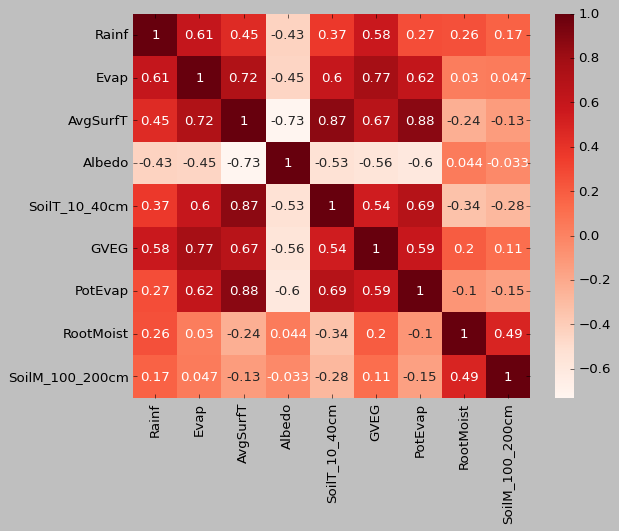

In [99]:
cor = X.corr()
sns.heatmap(cor, annot=True,cmap='Reds')

Usuniecie zmiennej *SoilT_10_40cm*. Cechuje sie ona malym zyskiem informacji i duza korelacja ze zmiennąa *AvgSurfT*.

In [122]:
# na ten moment odstapilem od usuniecia, po usunieciu accuracy wychodzi 80% na testowym.
#X_train = X_train.drop('SoilT_10_40cm',axis=1)
#X_test = X_test.drop('SoilT_10_40cm',axis=1)

#### Zbalansowanie datasetu

In [123]:
def plot_data_dist(y: pd.DataFrame) -> None:
  dane = pd.Series(y).value_counts().sort_index()
  labels = list(np.sort(pd.unique(y)))
  ypos=np.arange(len(labels))
  plt.xticks(ypos, labels)
  plt.xlabel('Klasa')
  plt.ylabel('Czestosc')
  plt.title('Liczebnosc dla proby')
  plt.bar(ypos,dane)

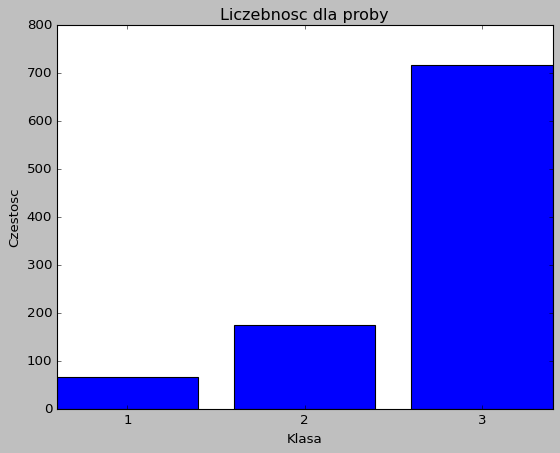

In [124]:
plot_data_dist(y_train)

In [125]:
from typing import Optional, Tuple
from pandas import DataFrame
from imblearn.over_sampling import RandomOverSampler, SMOTE

class BalanceDataSet():
  '''
  Two techniques for handling imbalanced data.
  '''
  def __init__(
      self,
      X: DataFrame,
      y: DataFrame
      ) -> None:
      self.X = X
      self.y = y
      assert len(self.X)==len(self.y)

  def useOverSampling(
      self,
      randon_seed: Optional[int] = 2023
      ) -> Tuple[DataFrame, DataFrame]:
    oversample = RandomOverSampler( sampling_strategy='auto',
                  random_state=randon_seed)
    return oversample.fit_resample(self.X, self.y)

  def useSMOTE(
      self,
      randon_seed: Optional[int] = 2023
      ) -> Tuple[DataFrame, DataFrame]:
    smote = SMOTE(random_state=randon_seed)
    return smote.fit_resample(self.X, self.y)

In [134]:
X_train_bal, y_train_bal = BalanceDataSet(X_train, y_train).useSMOTE()

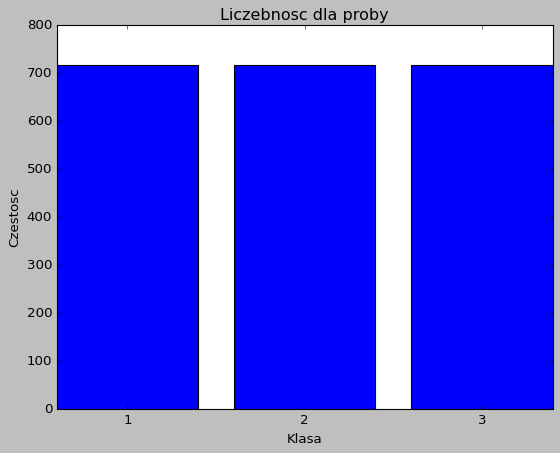

In [127]:
plot_data_dist(y_train_bal)

### Drzewa decyzyjne

In [78]:
from sklearn import tree

In [136]:
tree_classifier = tree.DecisionTreeClassifier(random_state = 2023)

In [137]:
tree_classifier.fit(X_train_bal, y_train_bal)

DecisionTreeClassifier(random_state=2023)

In [138]:
print("classifier accuracy {:.2f}%".format(tree_classifier.score(X_test,  y_test) * 100))


classifier accuracy 84.17%


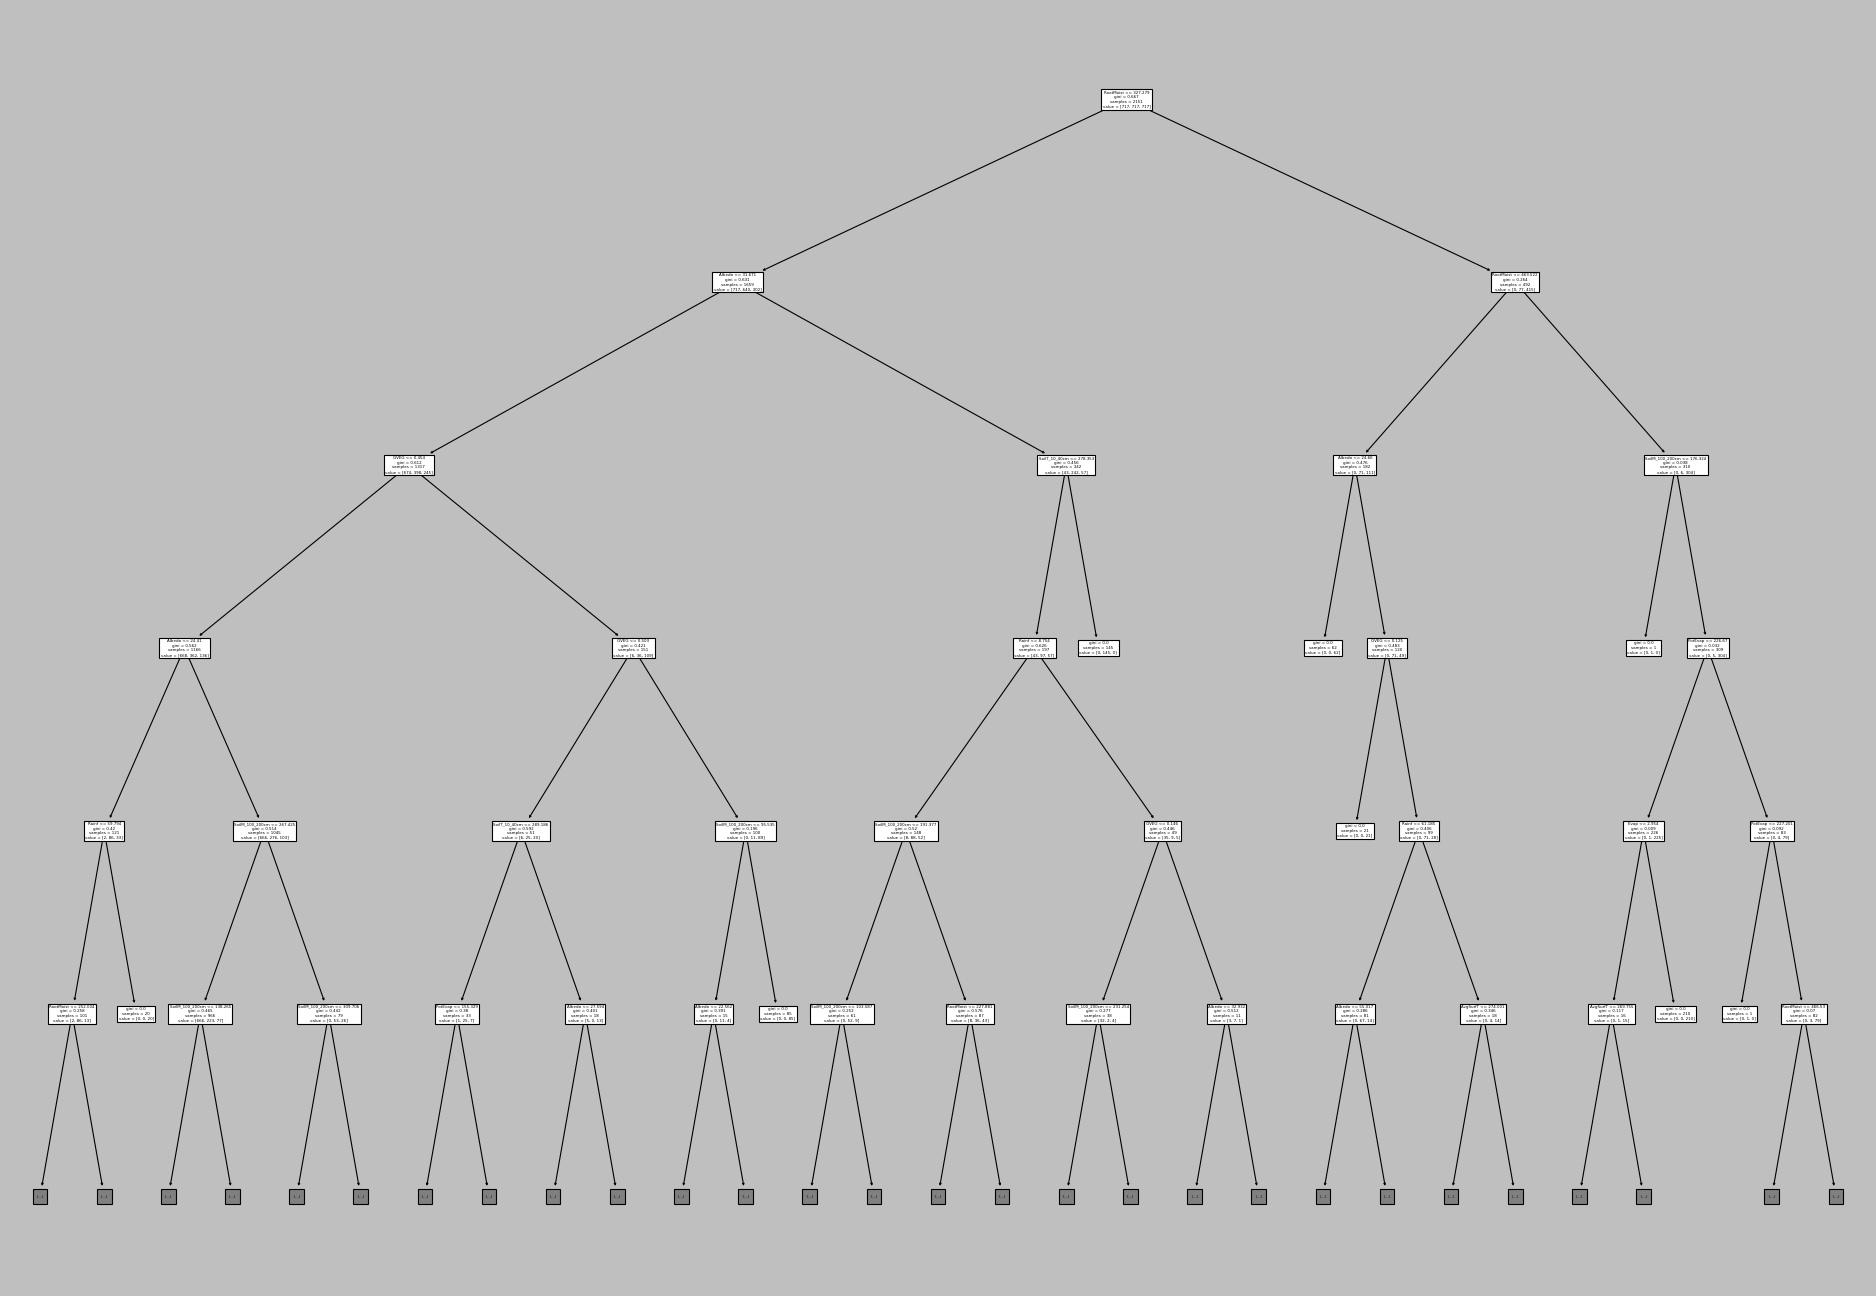

In [145]:
%matplotlib inline
plt.style.use("classic")
plt.figure(figsize=(30,20))
tree.plot_tree(tree_classifier, max_depth=5, feature_names=X.columns);

### Ocena modelu

In [84]:
def summary_model(model, X:pd.DataFrame, y:pd.DataFrame) -> None:
  y_pred = model.predict(X)
  y_real= y
  cf_matrix = confusion_matrix(y_real, y_pred)
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(3,3)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds',xticklabels=['1','2','3'],yticklabels=['1','2','3'])
  plt.xlabel('Predykcja')
  plt.ylabel('Rzeczywistość')
  plt.show()

Na danych testowych.

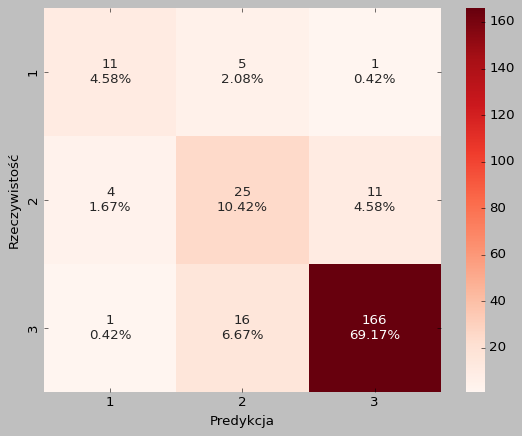

In [140]:
summary_model(tree_classifier, X_test, y_test)

In [141]:
y_test_predict = tree_classifier.predict(X_test)

In [142]:
 print(classification_report(y_test,y_test_predict ))

              precision    recall  f1-score   support

           1       0.69      0.65      0.67        17
           2       0.54      0.62      0.58        40
           3       0.93      0.91      0.92       183

    accuracy                           0.84       240
   macro avg       0.72      0.73      0.72       240
weighted avg       0.85      0.84      0.85       240



Na zbalansowanych danych testowych.

In [143]:
X_test_bal, y_test_bal = BalanceDataSet(X_test, y_test).useSMOTE()

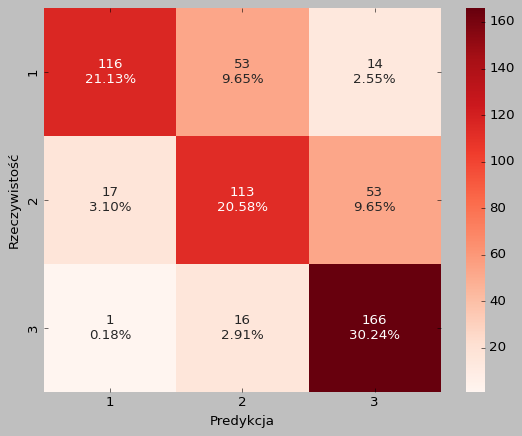

In [144]:
summary_model(tree_classifier, X_test_bal, y_test_bal)

### Zapisanie modelu

In [88]:
model_path='/content/drive/MyDrive/Colab Notebooks/Analiza BIG DATA/Sprint 2/Modele/tree_classifier'

In [89]:
with open(model_path, 'wb') as files:
    pickle.dump(tree_classifier, files)

### Odczyt modelu

In [ ]:
with open(model_path , 'rb') as f:
    model = pickle.load(f)